In [1]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

from dask.distributed import LocalCluster, Client
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(
    queue='shared',
    account="inspire",
    cores=6,
    memory="80 GB",
    processes=True,
    log_directory='/home/tford/dev/dask-logs',
    walltime="02:00:00",  # Request a longer time
)
cluster.scale(32)

client = Client(cluster)

print(client.dashboard_link)

In [2]:
workers = 8

cluster = LocalCluster(
    n_workers=workers,
    processes=True, 
)

client = Client(cluster)

print(client.dashboard_link)

http://127.0.0.1:8787/status


In [3]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(country="United States", downsample_factor=9, nsrdb_attributes=pvdeg.pysam.INSPIRE_NSRDB_ATTRIBUTES)

/home/tford/.conda-envs/geospatial/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


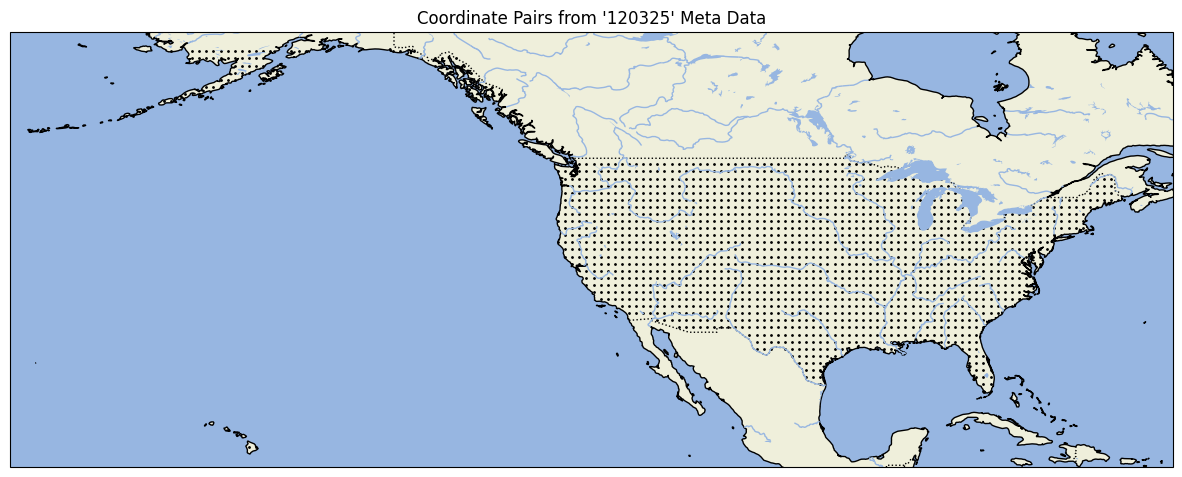

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': "Coordinate Pairs from '120325' Meta Data"}>)

In [4]:
locationGetter.plot_coords()

In [ ]:
# this shows us that the data for poa_front is repeated 25 times for tmy, all years are the samer
res = pvdeg.pysam.pysam(
    pvdeg.weather.roll_tmy(locationGetter.weather_data.isel(gid=0).to_dataframe(), locationGetter.meta_data.iloc[0].to_dict()),
    locationGetter.meta_data.iloc[0].to_dict(),
    #pv_model = "pysamv1",
    config_files = {"pv" : '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json'}
)

# for i in range(25):
#     for j in range(25):
#         if i == j:
#             print("same year")
#             continue

#         if res["poa_rear"][j * 8760 : (j * 8760) + 1] == res["poa_rear"][i * 8760 : i * 8760 + 1]:
#             print("equal")    
#         else:
#             print(i, j, "not equal")

In [5]:
inspire_ds = pvdeg.pysam.inspire_ground_irradiance(
    locationGetter.weather_data.isel(gid=0).to_dataframe(),  # function handles UTC -> local for us
    locationGetter.meta_data.iloc[0].to_dict(),
    config_files = {"pv" : '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json'}
)   

In [9]:
inspire_ds.compute()

<xarray.Dataset> Size: 2MB
Dimensions:              (time: 8760, distance: 10)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2001-01-01T00:30:00 ... 2...
  * distance             (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables: (12/15)
    annual_poa           float64 8B 7.821e+05
    annual_energy        float64 8B 1.333e+05
    poa_front            (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    poa_rear             (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    subarray1_poa_front  (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    subarray1_poa_rear   (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    dhi                  (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi                  (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dni                  (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    relative_humidity    (time) float64 70kB 89.53 90.07 90.09 ... 85.99 86.95
    albedo               (time) float64 70kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ground_irradiance    (time, distance) float64 701kB 0.0 0.0 0.0 ... 0.0 0.0

In [22]:
geo_weather, geo_meta = locationGetter.get_geospatial_data()

geo_meta = geo_meta[geo_meta['state'] != "Alaska"]
geo_weather = geo_weather.sel(gid=geo_meta.index).chunk({"gid":4}).isel(gid=slice(0, 1600)) # exclusive upper bound

In [29]:
shapes = {
    "annual_poa": ("gid",),
    "annual_energy": ("gid",),
    "poa_front": ("gid", "time"),
    "poa_rear": ("gid", "time"),
    "subarray1_poa_front": ("gid", "time"),
    "subarray1_poa_rear": ("gid", "time"),
    "temp_air": ("gid", "time"),
    "wind_speed": ("gid", "time"),
    "wind_direction": ("gid", "time"),
    "dhi": ("gid", "time"),
    "ghi": ("gid", "time"),
    "dni": ("gid", "time"),
    "relative_humidity": ("gid", "time"),
    "albedo": ("gid", "time"),
    "ground_irradiance": ("gid", "time", "distance")
}

template = pvdeg.geospatial.output_template(
    ds_gids = geo_weather.isel(gid=slice(500,510)), # times will cause error, fix below
    shapes = shapes,
    add_dims={"distance" : 10}, # this will autogenerate a range of length 10 for the coordinate axis
)

# modified range as produced by the corrected times for the tmy dataset
# might just be able to set this to geo weather time because function returns UTC
template['time'] = pd.date_range(start='2001-01-01 00:30:00', freq='1h', periods=8760)

In [15]:
client.scatter(geo_meta, broadcast=True)
# we do not want to scatter weather because it is larger than memory and will cause problems

<Future: finished, type: pandas.core.frame.DataFrame, key: DataFrame-1da4669bca4088d25e3e38e623fbb5f5>

In [35]:
confs = ["02", "03"]

for conf in confs:

    pysam_tiny_res = pvdeg.geospatial.analysis(
        weather_ds = geo_weather.isel(gid=slice(500,510)).chunk({"gid":1}),
        meta_df = geo_meta.iloc[500:510],
        func = pvdeg.pysam.inspire_ground_irradiance, 
        template = template.chunk({"gid":1}),
        config_files = {"pv" : f'/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json'}
    )
    
    pysam_tiny_res.to_netcdf(f"agrivoltaics-irradiance-conf{conf}.h5", engine="h5netcdf")

/home/tford/.conda-envs/geospatial/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 14.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/tford/.conda-envs/geospatial/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 14.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [34]:
import os

os.getcwd()

'/home/tford/dev/PVDegradationTools/scripts/inspire_notebooks/pvd_job_120325'

In [ ]:
loaded = xr.open_dataset('downsample20-conf01-pysam-ground-irradiance.nc', engine="h5netcdf").compute()